<a href="https://colab.research.google.com/github/kimsooyoung/pytorch_til/blob/main/basic_tutorial/2_dataset_and_dataloader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 데이터셋 불러오기

TorchVision 에서 Fashion-MNIST 데이터셋을 불러오는 예제를 살펴보겠습니다. Fashion-MNIST는 Zalando의 기사 이미지 데이터셋으로 60,000개의 학습 예제와 10,000개의 테스트 예제로 이루어져 있습니다. 각 예제는 흑백(grayscale)의 28x28 이미지와 10개 분류(class) 중 하나인 정답(label)으로 구성됩니다.

다음 매개변수들을 사용하여 FashionMNIST 데이터셋 을 불러옵니다:
- root 는 학습/테스트 데이터가 저장되는 경로입니다.
- train 은 학습용 또는 테스트용 데이터셋 여부를 지정합니다.
- download=True 는 root 에 데이터가 없는 경우 인터넷에서 다운로드합니다.
- transform 과 target_transform 은 특징(feature)과 정답(label) 변형(transform)을 지정합니다.

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

데이터셋을 순회하고 시각화하기

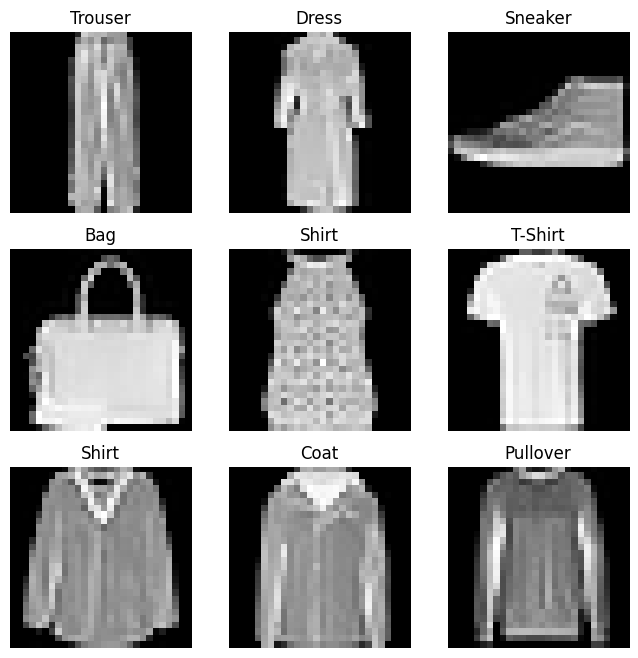

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## 파일에서 사용자 정의 데이터셋 만들기

사용자 정의 Dataset 클래스는 반드시 3개 함수를 구현해야 합니다: `__init__`, `__len__`, and `__getitem__`. 아래 구현을 살펴보면 FashionMNIST 이미지들은 img_dir 디렉토리에 저장되고, 정답은 annotations_file csv 파일에 별도로 저장됩니다.

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

`__init__` 함수는 Dataset 객체가 생성(instantiate)될 때 한 번만 실행됩니다. 여기서는 이미지와 주석 파일(annotation_file)이 포함된 디렉토리와 (다음 장에서 자세히 살펴볼) 두가지 변형(transform)을 초기화합니다.

labels.csv 파일은 다음과 같습니다:

```
tshirt1.jpg, 0
tshirt2.jpg, 0
......
ankleboot999.jpg, 9
```

`__len__` 함수는 데이터셋의 샘플 개수를 반환합니다.

`__getitem__` 함수는 주어진 인덱스 idx 에 해당하는 샘플을 데이터셋에서 불러오고 반환합니다. 인덱스를 기반으로, 디스크에서 이미지의 위치를 식별하고, read_image 를 사용하여 이미지를 텐서로 변환하고, self.img_labels 의 csv 데이터로부터 해당하는 정답(label)을 가져오고, (해당하는 경우) 변형(transform) 함수들을 호출한 뒤, 텐서 이미지와 라벨을 Python 사전(dict)형으로 반환합니다.

## DataLoader로 학습용 데이터 준비하기

Dataset 은 데이터셋의 특징(feature)을 가져오고 하나의 샘플에 정답(label)을 지정하는 일을 한 번에 합니다. 모델을 학습할 때, 일반적으로 샘플들을 《미니배치(minibatch)》로 전달하고, 매 에폭(epoch)마다 데이터를 다시 섞어서 과적합(overfit)을 막고, Python의 multiprocessing 을 사용하여 데이터 검색 속도를 높이려고 합니다.


DataLoader 는 간단한 API로 이러한 복잡한 과정들을 추상화한 순회 가능한 객체(iterable)입니다.

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

DataLoader를 통해 순회하기(iterate)

DataLoader 에 데이터셋을 불러온 뒤에는 필요에 따라 데이터셋을 순회(iterate)할 수 있습니다. 아래의 각 순회(iteration)는 (각각 batch_size=64 의 특징(feature)과 정답(label)을 포함하는) train_features 와 train_labels 의 묶음(batch)을 반환합니다. shuffle=True 로 지정했으므로, 모든 배치를 순회한 뒤 데이터가 섞입니다. (데이터 불러오기 순서를 보다 세밀하게(finer-grained) 제어하려면 Samplers 를 살펴보세요.)


Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


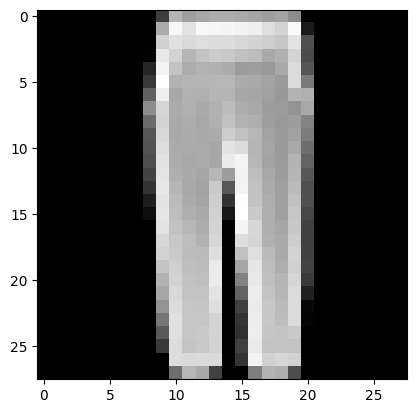

Label: 1


In [ ]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

결국 Dataset는 데이터셋을 손쉽게 다루기 위한 클래스, DataLoader는 Dataset을 통해 불러온 데이터를 손쉽게 순회할 수 있게 하기 위한 도구